In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
import pandas as pd
import os
import numpy as np
from PIL import Image
from torch.utils import data
from tqdm import tqdm
from suppfun import *

In [2]:
#read in splitted set
traindf = pd.read_csv('Data/train_set.csv')
valdf = pd.read_csv('Data/val_set.csv')
testdf = pd.read_csv('Data/test_set.csv')
#trainvaldf = pd.concat([traindf,valdf], ignore_index = True)

In [8]:
traindf = pd.concat([traindf, valdf], ignore_index = True)

In [9]:
#define path
data_path = "./Data/all"    
action_name_path = "./Data/labels.pkl"
save_model_path = "./Conv3D_ckpt/"

In [10]:
# 3D CNN parameters
fc_hidden1, fc_hidden2 = 200, 200
dropout = 0.3        # dropout probability

# training parameters
k = 10            # number of target category
epochs = 15
batch_size = 32
learning_rate = 1e-4
log_interval = 10
img_x, img_y = 150, 200  # resize video 2d frame size

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 11, 1

def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()
        output = model(X)  # output size = (batch, number of classes)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores


def validation(model, device, optimizer, test_loader, epoch):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output = model(X)

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss, test_score


def main():
    # Detect devices
    use_cuda = torch.cuda.is_available()                   # check if GPU exists
    device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

    # load UCF101 actions names
    params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}

    # load UCF101 actions names
    with open(action_name_path, 'rb') as f:
        action_names = pickle.load(f)   # load UCF101 actions names

    # convert labels -> category
    le = LabelEncoder()
    le.fit(action_names)

    # show how many classes there are
    list(le.classes_)

    # convert category -> 1-hot
    action_category = le.transform(action_names).reshape(-1, 1)
    enc = OneHotEncoder()
    enc.fit(action_category)

    # # example
    # y = ['HorseRace', 'YoYo', 'WalkingWithDog']
    # y_onehot = labels2onehot(enc, le, y)
    # y2 = onehot2labels(le, y_onehot)

    '''
    train_test_split
    '''

    # #actions = []
    # # fnames = os.listdir(data_path)

    # # all_names = []
    # # for f in fnames:
    # #     all_names.append(f)

    # # with open('Data/labels.pkl', 'rb') as ff:
    # #     actions = pickle.load(ff)

    # actions = trainvaldf['Label'].tolist()
    # all_names = trainvaldf['Index'].tolist()

    # # list all data files
    # all_X_list = all_names              # all video file names
    # all_y_list = labels2cat(le, actions)    # all video labels

    # # train, test split
    # train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.1/0.9, random_state=42)


    train_list = list(map(str,traindf['Index'].tolist()))
    test_list = list(map(str,testdf['Index'].tolist()))
    train_label = labels2cat(le, traindf['Label'].tolist())
    test_label = labels2cat(le, testdf['Label'].tolist())



    # image transformation
    transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])

    selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

    train_set, valid_set = Dataset_3DCNN(data_path, train_list, train_label, selected_frames, transform=transform), \
                           Dataset_3DCNN(data_path, test_list, test_label, selected_frames, transform=transform)
    train_loader = data.DataLoader(train_set, **params)
    valid_loader = data.DataLoader(valid_set, **params)

    # create model
    cnn3d = CNN3D(t_dim=len(selected_frames), img_x=img_x, img_y=img_y,
                  drop_p=dropout, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2, num_classes=k).to(device)


    # Parallelize model to multiple GPUs
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        cnn3d = nn.DataParallel(cnn3d)

    optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate)   # optimize all cnn parameters


    # record training process
    epoch_train_losses = []
    epoch_train_scores = []
    epoch_test_losses = []
    epoch_test_scores = []

    # start training
    for epoch in range(epochs):
        # train, test model
        train_losses, train_scores = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
        epoch_test_loss, epoch_test_score = validation(cnn3d, device, optimizer, valid_loader,epoch)

        # save results
        epoch_train_losses.append(train_losses)
        epoch_train_scores.append(train_scores)
        epoch_test_losses.append(epoch_test_loss)
        epoch_test_scores.append(epoch_test_score)

        # save all train test results
        A = np.array(epoch_train_losses)
        B = np.array(epoch_train_scores)
        C = np.array(epoch_test_losses)
        D = np.array(epoch_test_scores)
        np.save('./3DCNN_epoch_training_losses.npy', A)
        np.save('./3DCNN_epoch_training_scores.npy', B)
        np.save('./3DCNN_epoch_test_loss.npy', C)
        np.save('./3DCNN_epoch_test_score.npy', D)

    # plot
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
    plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
    plt.title("model loss")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train', 'test'], loc="upper left")
    # 2nd figure
    plt.subplot(122)
    plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
    plt.plot(np.arange(1, epochs + 1), D)         #  test accuracy (on epoch end)
    # plt.plot(histories.losses_val)
    plt.title("training scores")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc="upper left")
    title = "./fig_JESTER_3DCNN.png"
    plt.savefig(title, dpi=600)
    # plt.close(fig)
    plt.show()

In [11]:
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU
print(device)

cuda


Train Epoch: 1 [320/12702 (3%)]	Loss: 2.341805, Accu: 12.50%
Train Epoch: 1 [640/12702 (5%)]	Loss: 2.343843, Accu: 6.25%
Train Epoch: 1 [960/12702 (8%)]	Loss: 2.369688, Accu: 9.38%
Train Epoch: 1 [1280/12702 (10%)]	Loss: 2.269604, Accu: 15.62%
Train Epoch: 1 [1600/12702 (13%)]	Loss: 2.331365, Accu: 6.25%
Train Epoch: 1 [1920/12702 (15%)]	Loss: 2.297497, Accu: 12.50%
Train Epoch: 1 [2240/12702 (18%)]	Loss: 2.352239, Accu: 6.25%
Train Epoch: 1 [2560/12702 (20%)]	Loss: 2.315381, Accu: 9.38%
Train Epoch: 1 [2880/12702 (23%)]	Loss: 2.329042, Accu: 6.25%
Train Epoch: 1 [3200/12702 (25%)]	Loss: 2.285373, Accu: 18.75%
Train Epoch: 1 [3520/12702 (28%)]	Loss: 2.307982, Accu: 15.62%
Train Epoch: 1 [3840/12702 (30%)]	Loss: 2.358641, Accu: 12.50%
Train Epoch: 1 [4160/12702 (33%)]	Loss: 2.288486, Accu: 6.25%
Train Epoch: 1 [4480/12702 (35%)]	Loss: 2.309194, Accu: 15.62%
Train Epoch: 1 [4800/12702 (38%)]	Loss: 2.300680, Accu: 6.25%
Train Epoch: 1 [5120/12702 (40%)]	Loss: 2.362399, Accu: 12.50%
Train 

Train Epoch: 4 [3520/12702 (28%)]	Loss: 2.272474, Accu: 15.62%
Train Epoch: 4 [3840/12702 (30%)]	Loss: 2.303039, Accu: 6.25%
Train Epoch: 4 [4160/12702 (33%)]	Loss: 2.282720, Accu: 12.50%
Train Epoch: 4 [4480/12702 (35%)]	Loss: 2.289447, Accu: 12.50%
Train Epoch: 4 [4800/12702 (38%)]	Loss: 2.225366, Accu: 25.00%
Train Epoch: 4 [5120/12702 (40%)]	Loss: 2.261981, Accu: 21.88%
Train Epoch: 4 [5440/12702 (43%)]	Loss: 2.245713, Accu: 18.75%
Train Epoch: 4 [5760/12702 (45%)]	Loss: 2.309888, Accu: 15.62%
Train Epoch: 4 [6080/12702 (48%)]	Loss: 2.324617, Accu: 3.12%
Train Epoch: 4 [6400/12702 (50%)]	Loss: 2.215560, Accu: 21.88%
Train Epoch: 4 [6720/12702 (53%)]	Loss: 2.324047, Accu: 12.50%
Train Epoch: 4 [7040/12702 (55%)]	Loss: 2.289526, Accu: 6.25%
Train Epoch: 4 [7360/12702 (58%)]	Loss: 2.314249, Accu: 3.12%
Train Epoch: 4 [7680/12702 (60%)]	Loss: 2.248768, Accu: 9.38%
Train Epoch: 4 [8000/12702 (63%)]	Loss: 2.330071, Accu: 15.62%
Train Epoch: 4 [8320/12702 (65%)]	Loss: 2.244132, Accu: 15.6

Train Epoch: 7 [6720/12702 (53%)]	Loss: 1.947954, Accu: 37.50%
Train Epoch: 7 [7040/12702 (55%)]	Loss: 2.099694, Accu: 25.00%
Train Epoch: 7 [7360/12702 (58%)]	Loss: 2.019483, Accu: 25.00%
Train Epoch: 7 [7680/12702 (60%)]	Loss: 1.569023, Accu: 50.00%
Train Epoch: 7 [8000/12702 (63%)]	Loss: 2.120740, Accu: 25.00%
Train Epoch: 7 [8320/12702 (65%)]	Loss: 2.046421, Accu: 28.12%
Train Epoch: 7 [8640/12702 (68%)]	Loss: 1.986940, Accu: 28.12%
Train Epoch: 7 [8960/12702 (71%)]	Loss: 1.981984, Accu: 34.38%
Train Epoch: 7 [9280/12702 (73%)]	Loss: 1.887097, Accu: 31.25%
Train Epoch: 7 [9600/12702 (76%)]	Loss: 1.846348, Accu: 40.62%
Train Epoch: 7 [9920/12702 (78%)]	Loss: 1.853554, Accu: 31.25%
Train Epoch: 7 [10240/12702 (81%)]	Loss: 1.896685, Accu: 40.62%
Train Epoch: 7 [10560/12702 (83%)]	Loss: 2.062262, Accu: 37.50%
Train Epoch: 7 [10880/12702 (86%)]	Loss: 2.074084, Accu: 25.00%
Train Epoch: 7 [11200/12702 (88%)]	Loss: 2.017468, Accu: 28.12%
Train Epoch: 7 [11520/12702 (91%)]	Loss: 2.006555, 

Train Epoch: 10 [9600/12702 (76%)]	Loss: 2.158154, Accu: 28.12%
Train Epoch: 10 [9920/12702 (78%)]	Loss: 1.777578, Accu: 40.62%
Train Epoch: 10 [10240/12702 (81%)]	Loss: 1.777323, Accu: 28.12%
Train Epoch: 10 [10560/12702 (83%)]	Loss: 1.718503, Accu: 43.75%
Train Epoch: 10 [10880/12702 (86%)]	Loss: 1.655703, Accu: 46.88%
Train Epoch: 10 [11200/12702 (88%)]	Loss: 2.017046, Accu: 21.88%
Train Epoch: 10 [11520/12702 (91%)]	Loss: 1.714610, Accu: 37.50%
Train Epoch: 10 [11840/12702 (93%)]	Loss: 1.676073, Accu: 37.50%
Train Epoch: 10 [12160/12702 (96%)]	Loss: 1.944494, Accu: 28.12%
Train Epoch: 10 [12480/12702 (98%)]	Loss: 1.935160, Accu: 25.00%

Test set (1411 samples): Average loss: 1.9379, Accuracy: 33.24%

Epoch 10 model saved!
Train Epoch: 11 [320/12702 (3%)]	Loss: 1.482299, Accu: 37.50%
Train Epoch: 11 [640/12702 (5%)]	Loss: 1.843349, Accu: 37.50%
Train Epoch: 11 [960/12702 (8%)]	Loss: 2.012330, Accu: 31.25%
Train Epoch: 11 [1280/12702 (10%)]	Loss: 1.500497, Accu: 43.75%
Train Epoch: 1

Train Epoch: 13 [11840/12702 (93%)]	Loss: 1.477202, Accu: 37.50%
Train Epoch: 13 [12160/12702 (96%)]	Loss: 1.510149, Accu: 56.25%
Train Epoch: 13 [12480/12702 (98%)]	Loss: 1.575286, Accu: 40.62%

Test set (1411 samples): Average loss: 2.0873, Accuracy: 28.84%

Epoch 13 model saved!
Train Epoch: 14 [320/12702 (3%)]	Loss: 1.628674, Accu: 40.62%
Train Epoch: 14 [640/12702 (5%)]	Loss: 1.772729, Accu: 50.00%
Train Epoch: 14 [960/12702 (8%)]	Loss: 1.890725, Accu: 31.25%
Train Epoch: 14 [1280/12702 (10%)]	Loss: 1.295313, Accu: 56.25%
Train Epoch: 14 [1600/12702 (13%)]	Loss: 1.516147, Accu: 50.00%
Train Epoch: 14 [1920/12702 (15%)]	Loss: 1.770723, Accu: 31.25%
Train Epoch: 14 [2240/12702 (18%)]	Loss: 1.584349, Accu: 46.88%
Train Epoch: 14 [2560/12702 (20%)]	Loss: 1.536995, Accu: 53.12%
Train Epoch: 14 [2880/12702 (23%)]	Loss: 1.416406, Accu: 50.00%
Train Epoch: 14 [3200/12702 (25%)]	Loss: 1.425943, Accu: 50.00%
Train Epoch: 14 [3520/12702 (28%)]	Loss: 1.251592, Accu: 56.25%
Train Epoch: 14 [38

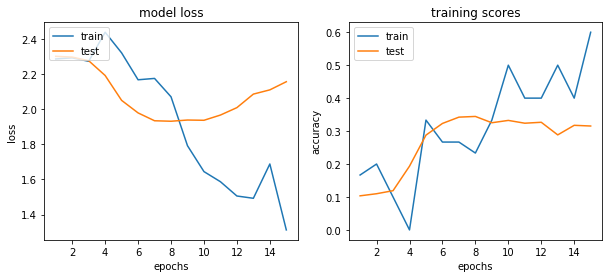

In [12]:
if __name__ == "__main__":
    main()